# Change point detection on RMS data

Sébastien MEYER, Adrienne TUYNMAN

First, you might want to run the notebook `download_seismic_data.ipynb`. This notebook allows you to download and prepare fine RMS values for performing change point detection.

In this notebook, we are going to evaluate different algorithms from the `ruptures` package for change point detection.

All the useful functions are already included in the source code.

In [1]:
from src.models.rms import load_rms, extract_rms_signal
from src.models.hub import fit_predict, evaluate, elbow_method, dp_bkps, p_bkps
from src.utils.data import replace_df, resample_df
from src.utils.plotting import plot_rms, plot_bkps, plot_elbow, plot_dp, plot_p, plot_nb

In [2]:
# These parameters are shared in the whole notebook
BAND = "[4.00, 14.00] Hz"

COST_NAME = "rbf"

## Load precomputed RMS data

We are going to load the RMS data as downloaded using default values in `download_seismic_data.ipynb`.

In [3]:
data_dir = "data"

start_date = "2020-01-01"
end_date = "2022-01-01"

output = "displacement"

rms_dfs = load_rms(
    data_dir=data_dir,
    start_date=start_date,
    end_date=end_date,
    output=output
)
rms_df = rms_dfs["FR.STR.00.BHZ"]

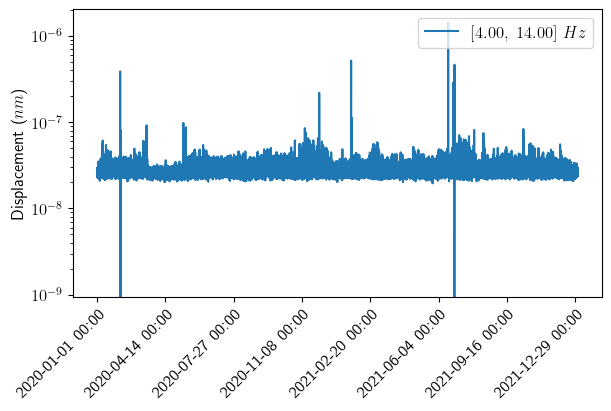

In [4]:
plot_rms(
    rms_df=rms_df,
    start_date_plot=start_date,
    end_date_plot=end_date,
    bands_plot=BAND,
    savefig=False
)

There are some missing values in the RMS displacement. Let us replace them with the median value of the whole sequence.

In [5]:
min_value = 2e-8
max_value = 1e-7

rms_df = replace_df(
    df=rms_df,
    min_value=min_value,
    max_value=max_value
)

Replacing values: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 570.73it/s]


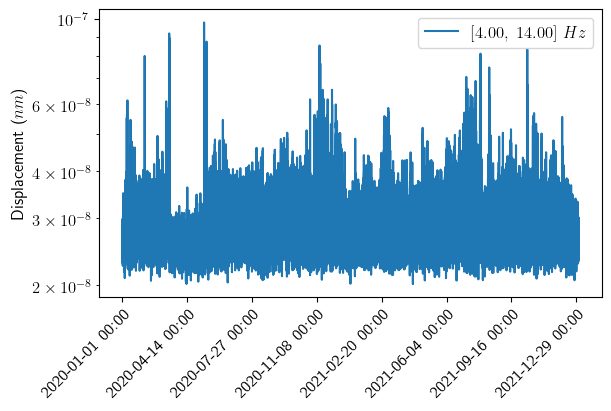

In [6]:
plot_rms(
    rms_df=rms_df,
    start_date_plot=start_date,
    end_date_plot=end_date,
    bands_plot=BAND,
    savefig=False
)

## A simple example: nationwide lockdown

We are interested in spotting the start and end dates of COVID lockdowns in France.

We can make a few remarks about the displacement:

- There are a few outliers at very specific points in time.
- There is more data (one sample every 15 minutes) than required for doing change point detection.

We choose to perform the following preprocessing, inspired from [Maciel et al.](https://github.com/sutaina/brasiliaNoise).

- Remove data between 7pm and 7am, as we do not expect much urban noise during this period.
- Resample data with a frequency of 1 day, taken as the median so as to be robust to outliers.

In [7]:
between_begin = "7:00"
between_end = "19:00"
freq = "1D"

rms_df_lkdwn = resample_df(
    df=rms_df,
    between_begin=between_begin,
    between_end=between_end,
    freq=freq
)

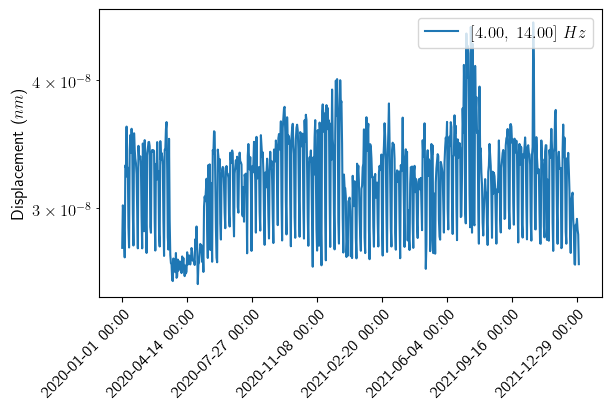

In [8]:
plot_rms(
    rms_df=rms_df_lkdwn,
    start_date_plot=start_date,
    end_date_plot=end_date,
    bands_plot=BAND,
    savefig=False
)

The data is already clearer for visualization. Now, we can proceed with change point detection. We already know the start and end dates of the nationwide lockdown that occurred in France.

- start of the lockdown: 15.03.2020 at 12pm
- end of the lockdown: 11.05.2020 at 12am

Let us use change point detection to detect this change. As we already know that 2 change points should occur, we can use the `Dynp` algorithm. 

In [9]:
start_date_signal = "2020-02-01"
end_date_signal = "2020-07-01"

important_dates = {
    "2020-03-15 12:00": "First nationwide lockdown starts",
    "2020-05-11 00:00": "First nationwide lockdown ends",
}

datelist, signal, true_bkps = extract_rms_signal(
    rms_df=rms_df_lkdwn,
    start_date_signal=start_date_signal,
    end_date_signal=end_date_signal,
    important_dates=list(important_dates.keys()),
    band=BAND
)

{'precision-recall': (1.0, 1.0), 'hausdorff': 2.0, 'randindex': 0.9826931567328918}


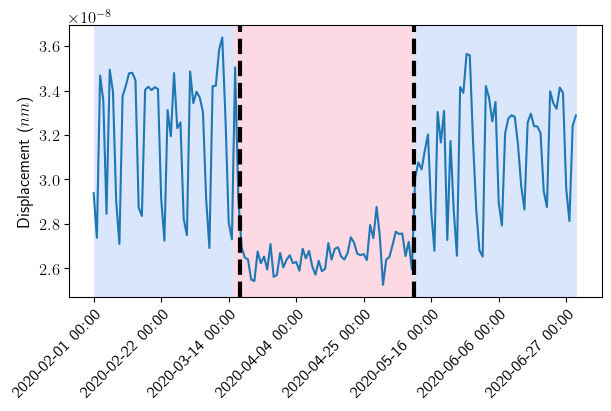

In [10]:
n_bkps = len(true_bkps) - 1

pred_bkps = fit_predict(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps=n_bkps
)

results_scores = evaluate(
    true_bkps,
    pred_bkps
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

If the number of breakpoints was unknown, we could use the elbow method to find it.

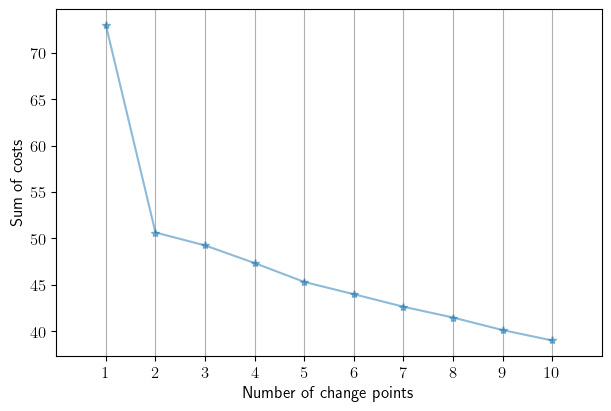

In [11]:
n_bkps_max = 10

array_of_n_bkps, array_of_costs = elbow_method(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_elbow(
    array_of_n_bkps=array_of_n_bkps,
    array_of_costs=array_of_costs,
    savefig=False
)

From the elbow method, it is quite clear that a value of 2 for the number of breakpoints is adapted to our situation.

Another method is to use `Pelt` algorithm with a penalty value. Again, choosing the penalty value can be difficult.

{'precision-recall': (1.0, 1.0), 'hausdorff': 2.0, 'randindex': 0.9826931567328918}


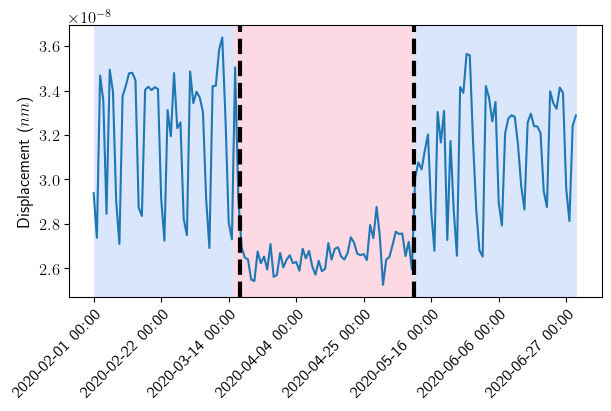

In [12]:
pen = 5

pred_bkps = fit_predict(
    signal=signal,
    cost_name=COST_NAME,
    pen=pen
)

results_scores = evaluate(
    true_bkps,
    pred_bkps
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

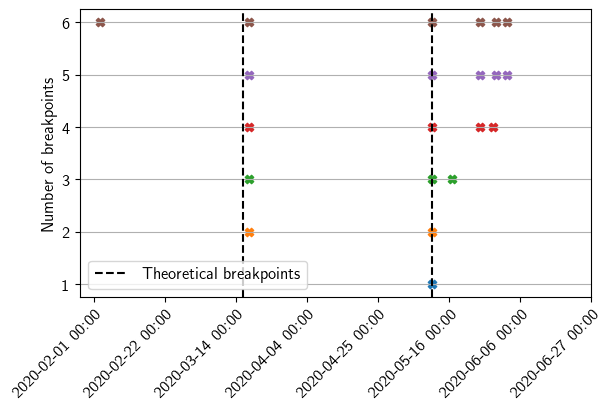

In [13]:
n_bkps_max = 6

array_of_n_bkps, list_of_bkps = dp_bkps(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_dp(
    true_bkps,
    list_of_bkps,
    datelist=datelist,
    savefig=False
)

### Second nationwide lockdown

The second lockdown in France has the following important dates:

- start of the lockdown: 30.10.2020 at 12pm
- end of the lockdown: 15.12.2020 at 12am

However, this lockdown was less strict than the first one. Moreover, the end date of the lockdown is not clear. Indeed, many shops reopened on 15.12.2020, while universities and schools only reopened on 20.01.2021.

Let us use change point detection to detect this change. As we already know that 2 change points should occur, we can use the `Dynp` algorithm. 

In [14]:
start_date_signal = "2020-10-01"
end_date_signal = "2021-03-01"

important_dates = {
    "2020-10-30": "Second nationwide lockdown starts",
    "2020-12-16": "Second nationwide lockdown ends (curfew)",
    "2021-01-16": "Second nationwide lockdown ends (totally)",
}

datelist, signal, true_bkps = extract_rms_signal(
    rms_df=rms_df_lkdwn,
    start_date_signal=start_date_signal,
    end_date_signal=end_date_signal,
    important_dates=list(important_dates.keys()),
    band=BAND
)

{'precision-recall': (0.6666666666666666, 0.6666666666666666), 'hausdorff': 17.0, 'randindex': 0.8720529801324504}


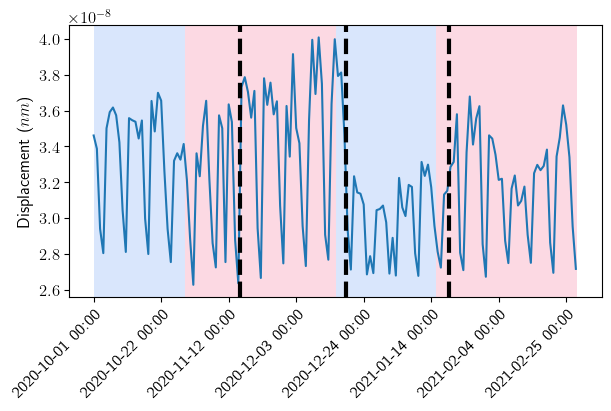

In [15]:
n_bkps = len(true_bkps) - 1

pred_bkps = fit_predict(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps=n_bkps
)

results_scores = evaluate(
    true_bkps,
    pred_bkps
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

Here, we have a correct detection of the breakpoints. However, we do not detect the dates as perfectly as for the first lockdown. Let us try to use the elbow method to find if another number of breakpoints would be better.

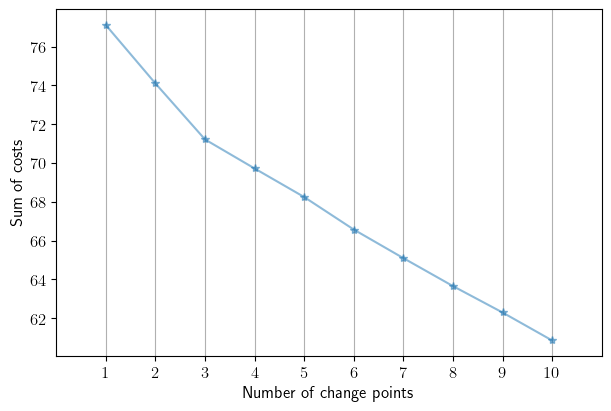

In [16]:
n_bkps_max = 10

array_of_n_bkps, array_of_costs = elbow_method(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_elbow(
    array_of_n_bkps=array_of_n_bkps,
    array_of_costs=array_of_costs,
    savefig=False
)

The elbow method is telling us that 2 breakpoints might be a better option. Let us use Pelt algorithm.

{'precision-recall': (0.6666666666666666, 0.6666666666666666), 'hausdorff': 17.0, 'randindex': 0.8720529801324504}


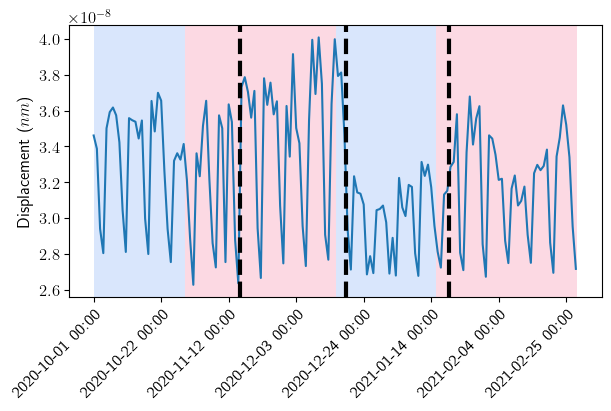

In [17]:
cost_name = "rbf"
# pen = 2
pen = 2.02  # yields better results!

pred_bkps = fit_predict(
    signal=signal,
    cost_name=cost_name,
    pen=pen
)

results_scores = evaluate(
    true_bkps,
    pred_bkps
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

We detect breakpoints with a slight difference of approximately two weeks between the predicted and the true breakpoints. This might be explained because the second lockdown was announced during the winter holidays in France, so people were already modifying their actions during the previous week(s). Moreover, many other measures such as a nationwide curfew (on October 17) were decided at the end of 2020. We could also explain it by the fact that, after the first lockdown, most people were more used to adapting their actions when the virus was surging (thus, the measures' dates are not equal to the dates at which people already take actions).

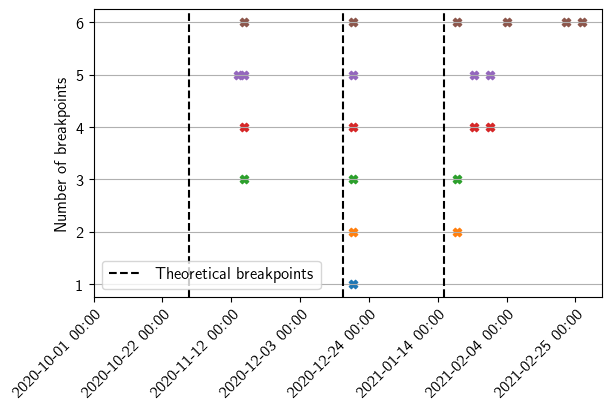

In [18]:
n_bkps_max = 6

array_of_n_bkps, list_of_bkps = dp_bkps(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_dp(
    true_bkps,
    list_of_bkps,
    datelist=datelist,
    savefig=False
)

## Detailed analysis: curfews

We noticed that it is more difficult to predict the second nationwide lockdown, as it happened in multiple steps and was less strict than the first one.

We would like to perform a finer analysis of the data. Indeed, a curfew was enforced in October 17, 2020 and the final curfew only ended in June 20, 2021. During that time, the start time of the curfew changed many times.

We choose to perform the following preprocessing:

- Keep all available data.
- Resample data with frequency 1 hour, taken as the median to be robust to outliers.

In [19]:
freq = "1H"

rms_df_cfw = resample_df(
    df=rms_df,
    freq=freq
)

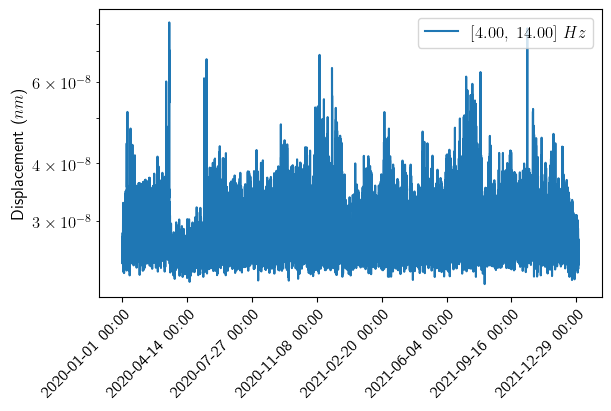

In [20]:
plot_rms(
    rms_df=rms_df_cfw,
    start_date_plot=start_date,
    end_date_plot=end_date,
    bands_plot=BAND,
    savefig=False
)

In [21]:
start_date_signal = "2020-10-01"
end_date_signal = "2021-07-14"

important_dates = {
    "2020-10-17": "Curfew 10pm-6am",
    "2020-10-30": "Second lockdown starts",
    "2020-12-16": "Curfew 8pm-6am",
    "2021-01-16": "Curfew 6pm-6am",
    "2021-03-20": "Curfew 7pm-6am",
    "2021-05-19": "Curfew 9pm-6am",
    "2021-06-09": "Curfew 11pm-6am",
    "2021-06-20": "Curfew ends"
}

datelist, signal, true_bkps = extract_rms_signal(
    rms_df=rms_df_cfw,
    start_date_signal=start_date_signal,
    end_date_signal=end_date_signal,
    important_dates=list(important_dates.keys()),
    band=BAND
)

{'precision-recall': (0.625, 0.625), 'hausdorff': 1458.0, 'randindex': 0.849609931571173}


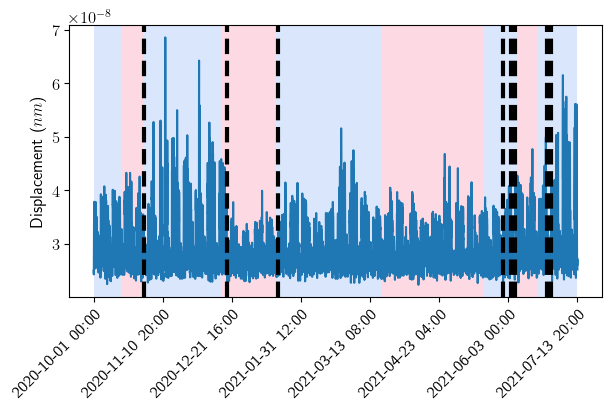

In [22]:
n_bkps = len(true_bkps) - 1

pred_bkps = fit_predict(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps=n_bkps
)

results_scores = evaluate(
    true_bkps,
    pred_bkps,
    margin=10*24  # 10 days
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

Here, we can observe that the model achieve relatively poor predictions. Indeed, it is able to spot only some of the dates. Interestingly, the breakpoints that are wrongly predicted often happen closely to other breakpoints.

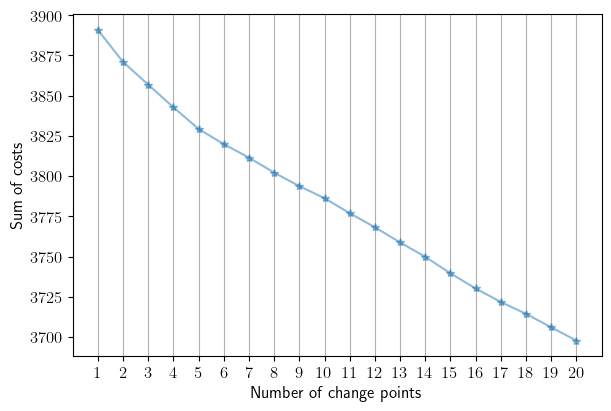

In [23]:
n_bkps_max = 20

array_of_n_bkps, array_of_costs = elbow_method(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_elbow(
    array_of_n_bkps=array_of_n_bkps,
    array_of_costs=array_of_costs,
    savefig=False
)

From the elbow method, it is not clear how many breakpoints occur.

{'precision-recall': (1.0, 0.625), 'hausdorff': 1458.0, 'randindex': 0.8483796426022858}


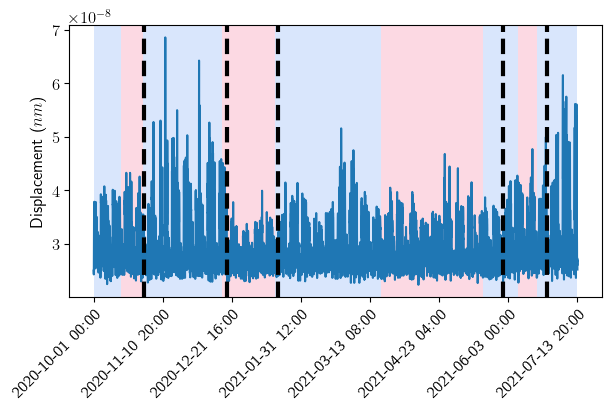

In [24]:
pen = 10

pred_bkps = fit_predict(
    signal=signal,
    cost_name=COST_NAME,
    pen=pen
)

results_scores = evaluate(
    true_bkps,
    pred_bkps,
    margin=10*24  # 10 days
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

When using Pelt algorithm, we can detect more precise breakpoints with no more duplicated signals. Five is also the number of breakpoints arising from elbow method (though not so clear).

Let us see the effect of the cost function on the predictions.

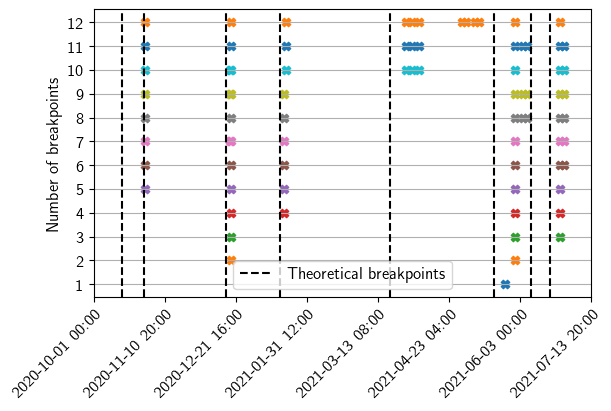

In [25]:
n_bkps_max = 12

array_of_n_bkps, list_of_bkps = dp_bkps(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_dp(
    true_bkps,
    list_of_bkps,
    datelist=datelist,
    savefig=False
)

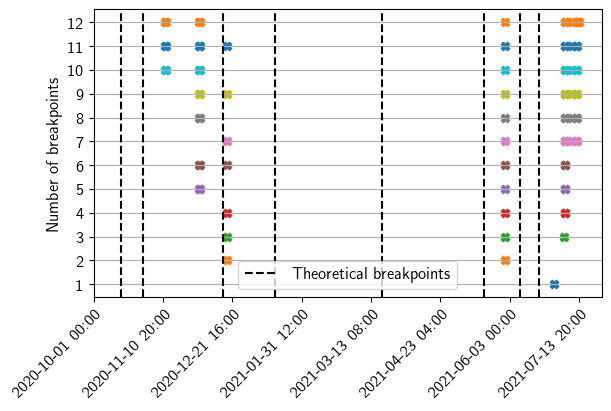

In [26]:
n_bkps_max = 12

array_of_n_bkps, list_of_bkps = dp_bkps(
    signal=signal,
    cost_name="linear",
    n_bkps_max=n_bkps_max
)

plot_dp(
    true_bkps,
    list_of_bkps,
    datelist=datelist,
    savefig=False
)

We can also see how changing the penality can influence the breakpoints detected by PELT.

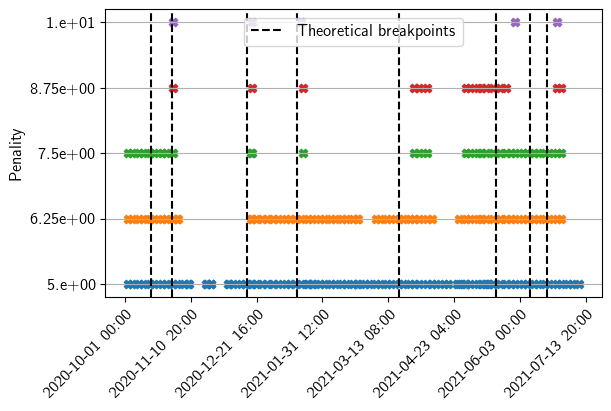

In [27]:
array_of_pens,list_of_bkps=p_bkps(
    signal=signal,
    cost_name="rbf",
    n_pts=5,
    min_pen=5,
    max_pen=10)

plot_p(
    true_bkps,
    list_of_bkps,
    datelist=datelist,
    array_of_pens=array_of_pens,
    savefig=False,
)

We can also compare this to the results we would have with a linear kernel.

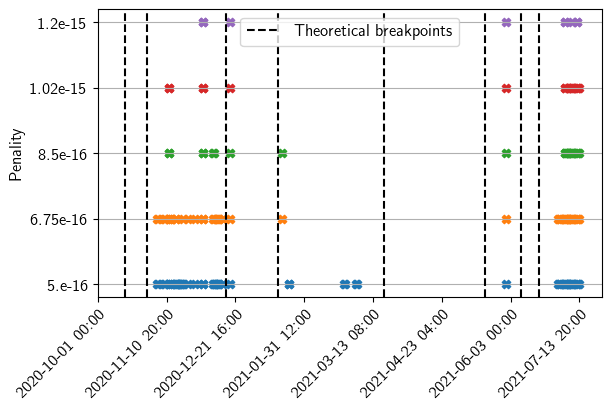

In [28]:
array_of_pens,list_of_bkps=p_bkps(
    signal=signal,
    cost_name="linear",
    n_pts=5,
    min_pen=5e-16,
    max_pen=1.2e-15)

plot_p(
    true_bkps,
    list_of_bkps,
    datelist=datelist,
    array_of_pens=array_of_pens,
    savefig=False,
)

Finally, we can display how many breakpoints PELT detects depending on the penality given.

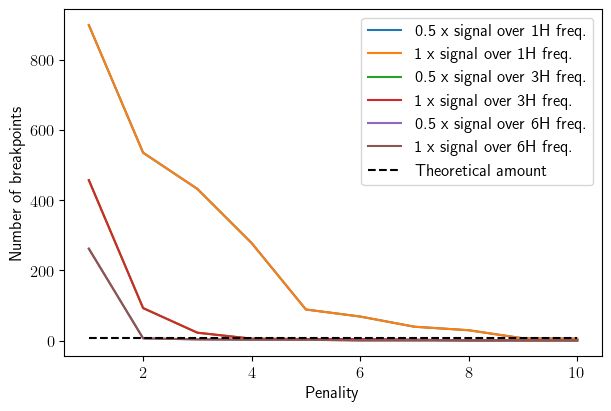

In [32]:
cost = "rbf"  # "linear","rbf"

max = 10  # rbf
# max = 1.5e-15  #linear

size = 10
freqs = ["1H","3H","6H"]
scals = [0.5, 1]
lists_of_bkps, labels = [], []

for freq in freqs:
    
    for scal in scals:
        
        rms_df_cfw = resample_df(df=rms_df, freq=freq)

        datelist, signal, true_bkps = extract_rms_signal(
            rms_df=rms_df_cfw,
            start_date_signal=start_date_signal,
            end_date_signal=end_date_signal,
            important_dates=list(important_dates.keys()),
            band=BAND
        )
        
        array_of_pens, list_of_bkps=p_bkps(
            signal=scal*signal,
            cost_name=cost,
            n_pts=size,
            min_pen=None,
            max_pen=max
        )
        
        lists_of_bkps.append(list_of_bkps)
        
        labels.append(f"{scal} x signal over {freq} freq.")
        
plot_nb(
    true_bkps=true_bkps,
    lists_of_bkps=lists_of_bkps,
    list_of_labels=labels,
    array_of_pens=array_of_pens,
    savefig=False
)

---